In [ ]:
## hide
#!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

In [9]:
#hide
from fastbook import *

# Application Architectures Deep Dive

We are now in the exciting position that we can fully understand the architectures that we have been using for our state-of-the-art models for computer vision, natural language processing, and tabular analysis. In this chapter, we're going to fill in all the missing details on how fastai's application models work and show you how to build the models they use.

We will also go back to the custom data preprocessing pipeline we saw in <<chapter_midlevel_data>> for Siamese networks and show you how you can use the components in the fastai library to build custom pretrained models for new tasks.

We'll start with computer vision.

## Computer Vision

For computer vision application we use the functions `cnn_learner` and `unet_learner` to build our models, depending on the task. In this section we'll explore how to build the `Learner` objects we used in Parts 1 and 2 of this book.

### cnn_learner

Let's take a look at what happens when we use the `cnn_learner` function. We begin by passing this function an architecture to use for the *body* of the network. Most of the time we use a ResNet, which you already know how to create, so we don't need to delve into that any further. Pretrained weights are downloaded as required and loaded into the ResNet.

Then, for transfer learning, the network needs to be *cut*. This refers to slicing off the final layer, which is only responsible for ImageNet-specific categorization. In fact, we do not slice off only this layer, but everything from the adaptive average pooling layer onwards. The reason for this will become clear in just a moment. Since different architectures might use different types of pooling layers, or even completely different kinds of *heads*, we don't just search for the adaptive pooling layer to decide where to cut the pretrained model. Instead, we have a dictionary of information that is used for each model to determine where its body ends, and its head starts. We call this `model_meta`—here it is for resnet-50:

In [ ]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

> jargon: Body and Head: The "head" of a neural net is the part that is specialized for a particular task. For a CNN, it's generally the part after the adaptive average pooling layer. The "body" is everything else, and includes the "stem" (which we learned about in <<chapter_resnet>>).

If we take all of the layers prior to the cut point of `-2`, we get the part of the model that fastai will keep for transfer learning. Now, we put on our new head. This is created using the function `create_head`:

In [ ]:
#hide_output
create_head(20,2)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=20, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

```
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=20, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)
```

With this function you can choose how many additional linear layers are added to the end, how much dropout to use after each one, and what kind of pooling to use. By default, fastai will apply both average pooling, and max pooling, and will concatenate the two together (this is the `AdaptiveConcatPool2d` layer). This is not a particularly common approach, but it was developed independently at fastai and other research labs in recent years, and tends to provide some small improvement over using just average pooling.

fastai is a bit different from most libraries in that by default it adds two linear layers, rather than one, in the CNN head. The reason for this is that transfer learning can still be useful even, as we have seen, when transferring the pretrained model to very different domains. However, just using a single linear layer is unlikely to be enough in these cases; we have found that using two linear layers can allow transfer learning to be used more quickly and easily, in more situations.

> note: One Last Batchnorm?: One parameter to `create_head` that is worth looking at is `bn_final`. Setting this to `true` will cause a batchnorm layer to be added as your final layer. This can be useful in helping your model scale appropriately for your output activations. We haven't seen this approach published anywhere as yet, but we have found that it works well in practice wherever we have used it.

Let's now take a look at what `unet_learner` did in the segmentation problem we showed in <<chapter_intro>>.

### unet_learner

One of the most interesting architectures in deep learning is the one that we used for segmentation in <<chapter_intro>>. Segmentation is a challenging task, because the output required is really an image, or a pixel grid, containing the predicted label for every pixel. There are other tasks that share a similar basic design, such as increasing the resolution of an image (*super-resolution*), adding color to a black-and-white image (*colorization*), or converting a photo into a synthetic painting (*style transfer*)—these tasks are covered by an [online](https://book.fast.ai/) chapter of this book, so be sure to check it out after you've read this chapter. In each case, we are starting with an image and converting it to some other image of the same dimensions or aspect ratio, but with the pixels altered in some way. We refer to these as *generative vision models*.

The way we do this is to start with the exact same approach to developing a CNN head as we saw in the previous problem. We start with a ResNet, for instance, and cut off the adaptive pooling layer and everything after that. Then we replace those layers with our custom head, which does the generative task.

There was a lot of handwaving in that last sentence! How on earth do we create a CNN head that generates an image? If we start with, say, a 224-pixel input image, then at the end of the ResNet body we will have a 7×7 grid of convolutional activations. How can we convert that into a 224-pixel segmentation mask?

Naturally, we do this with a neural network! So we need some kind of layer that can increase the grid size in a CNN. One very simple approach to this is to replace every pixel in the 7×7 grid with four pixels in a 2×2 square. Each of those four pixels will have the same value—this is known as *nearest neighbor interpolation*. PyTorch provides a layer that does this for us, so one option is to create a head that contains stride-1 convolutional layers (along with batchnorm and ReLU layers as usual) interspersed with 2×2 nearest neighbor interpolation layers. In fact, you can try this now! See if you can create a custom head designed like this, and try it on the CamVid segmentation task. You should find that you get some reasonable results, although they won't be as good as our <<chapter_intro>> results.

Another approach is to replace the nearest neighbor and convolution combination with a *transposed convolution*, otherwise known as a *stride half convolution*. This is identical to a regular convolution, but first zero padding is inserted between all the pixels in the input. This is easiest to see with a picture—<<transp_conv>> shows a diagram from the excellent [convolutional arithmetic paper](https://arxiv.org/abs/1603.07285) we discussed in <<chapter_convolutions>>, showing a 3×3 transposed convolution applied to a 3×3 image.

<img alt="A transposed convolution" width="815" caption="A transposed convolution (courtesy of Vincent Dumoulin and Francesco Visin)" id="transp_conv" src="images/att_00051.png">

As you see, the result of this is to increase the size of the input. You can try this out now by using fastai's `ConvLayer` class; pass the parameter `transpose=True` to create a transposed convolution, instead of a regular one, in your custom head.

Neither of these approaches, however, works really well. The problem is that our 7×7 grid simply doesn't have enough information to create a 224×224-pixel output. It's asking an awful lot of the activations of each of those grid cells to have enough information to fully regenerate every pixel in the output. The solution to this problem is to use *skip connections*, like in a ResNet, but skipping from the activations in the body of the ResNet all the way over to the activations of the transposed convolution on the opposite side of the architecture. This approach, illustrated in <<unet>>, was developed by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in the 2015 paper ["U-Net: Convolutional Networks for Biomedical Image Segmentation"](https://arxiv.org/abs/1505.04597). Although the paper focused on medical applications, the U-Net has revolutionized all kinds of generative vision models.

<img alt="The U-Net architecture" width="630" caption="The U-Net architecture (courtesy of Olaf Ronneberger, Philipp Fischer, and Thomas Brox)" id="unet" src="images/att_00052.png">

This picture shows the CNN body on the left (in this case, it's a regular CNN, not a ResNet, and they're using 2×2 max pooling instead of stride-2 convolutions, since this paper was written before ResNets came along) and the transposed convolutional ("up-conv") layers on the right. Then extra skip connections are shown as gray arrows crossing from left to right (these are sometimes called *cross connections*). You can see why it's called a "U-Net!"

With this architecture, the input to the transposed convolutions is not just the lower-resolution grid in the preceding layer, but also the higher-resolution grid in the ResNet head. This allows the U-Net to use all of the information of the original image, as it is needed. One challenge with U-Nets is that the exact architecture depends on the image size. fastai has a unique `DynamicUnet` class that autogenerates an architecture of the right size based on the data provided.

Let's focus now on an example where we leverage the fastai library to write a custom model.

### A Siamese Network

In [ ]:
#hide
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
    
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
    
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Let's go back to the input pipeline we set up in <<chapter_midlevel_data>> for a Siamese network. If you remember, it consisted of pair of images with the label being `True` or `False`, depending on if they were in the same class or not.

Using what we just saw, let's build a custom model for this task and train it. How? We will use a pretrained architecture and pass our two images through it. Then we can concatenate the results and send them to a custom head that will return two predictions. In terms of modules, this looks like this:

In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

To create our encoder, we just need to take a pretrained model and cut it, as we explained before. The function `create_body` does that for us; we just have to pass it the place where we want to cut. As we saw earlier, per the dictionary of metadata for pretrained models, the cut value for a resnet is `-2`:

In [ ]:
encoder = create_body(resnet34, cut=-2)

Then we can create our head. A look at the encoder tells us the last layer has 512 features, so this head will need to receive `512*2`. Why 2? We have to multiply by 2 because we have two images. So we create the head as follows:

In [ ]:
head = create_head(512*2, 2, ps=0.5)

With our encoder and head, we can now build our model:

In [ ]:
model = SiameseModel(encoder, head)

Before using `Learner`, we have two more things to define. First, we must define the loss function we want to use. It's regular cross-entropy, but since our targets are Booleans, we need to convert them to integers or PyTorch will throw an error:

In [ ]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

More importantly, to take full advantage of transfer learning, we have to define a custom *splitter*. A splitter is a function that tells the fastai library how to split the model into parameter groups. These are used behind the scenes to train only the head of a model when we do transfer learning. 

Here we want two parameter groups: one for the encoder and one for the head. We can thus define the following splitter (`params` is just a function that returns all parameters of a given module):

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

Then we can define our `Learner` by passing the data, model, loss function, splitter, and any metric we want. Since we are not using a convenience function from fastai for transfer learning (like `cnn_learner`), we have to call `learn.freeze` manually. This will make sure only the last parameter group (in this case, the head) is trained:

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, 
                splitter=siamese_splitter, metrics=accuracy)
learn.freeze()

Then we can directly train our model with the usual methods:

In [ ]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.367015,0.281242,0.885656,00:26
1,0.307688,0.214721,0.915426,00:26
2,0.275221,0.170615,0.936401,00:26
3,0.223771,0.159633,0.943843,00:26


Before unfreezing and fine-tuning the whole model a bit more with discriminative learning rates (that is: a lower learning rate for the body and a higher one for the head):

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.212744,0.159033,0.944520,00:35
1,0.201893,0.159615,0.942490,00:35
2,0.204606,0.152338,0.945196,00:36
3,0.213203,0.148346,0.947903,00:36


94.8\% is very good when we remember a classifier trained the same way (with no data augmentation) had an error rate of 7%.

Now that we've seen how to create complete state-of-the-art computer vision models, let's move on to NLP.

## Natural Language Processing

Converting an AWD-LSTM language model into a transfer learning classifier, as we did in <<chapter_nlp>>, follows a very similar process to what we did with `cnn_learner` in the first section of this chapter. We do not need a "meta" dictionary in this case, because we do not have such a variety of architectures to support in the body. All we need to do is select the stacked RNN for the encoder in the language model, which is a single PyTorch module. This encoder will provide an activation for every word of the input, because a language model needs to output a prediction for every next word.

To create a classifier from this we use an approach described in the [ULMFiT paper](https://arxiv.org/abs/1801.06146) as "BPTT for Text Classification (BPT3C)":

> : We divide the document into fixed-length batches of size *b*. At the beginning of each batch, the model is initialized with the final state of the previous batch; we keep track of the hidden states for mean and max-pooling; gradients are back-propagated to the batches whose hidden states contributed to the final prediction. In practice, we use variable length backpropagation sequences.

In other words, the classifier contains a `for` loop, which loops over each batch of a sequence. The state is maintained across batches, and the activations of each batch are stored. At the end, we use the same average and max concatenated pooling trick that we use for computer vision models—but this time, we do not pool over CNN grid cells, but over RNN sequences.

For this `for` loop we need to gather our data in batches, but each text needs to be treated separately, as they each have their own labels. However, it's very likely that those texts won't all be of the same length, which means we won't be able to put them all in the same array, like we did with the language model.

That's where padding is going to help: when grabbing a bunch of texts, we determine the one with the greatest length, then we fill the ones that are shorter with a special token called `xxpad`. To avoid extreme cases where we have a text with 2,000 tokens in the same batch as a text with 10 tokens (so a lot of padding, and a lot of wasted computation), we alter the randomness by making sure texts of comparable size are put together. The texts will still be in a somewhat random order for the training set (for the validation set we can simply sort them by order of length), but not completely so.

This is done automatically behind the scenes by the fastai library when creating our `DataLoaders`.

## Tabular

Finally, let's take a look at `fastai.tabular` models. (We don't need to look at collaborative filtering separately, since we've already seen that these models are just tabular models, or use the dot product approach, which we've implemented earlier from scratch.)

Here is the `forward` method for `TabularModel`:

```python
if self.n_emb != 0:
    x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
    x = torch.cat(x, 1)
    x = self.emb_drop(x)
if self.n_cont != 0:
    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
return self.layers(x)
```

We won't show `__init__` here, since it's not that interesting, but we will look at each line of code in `forward` in turn. The first line:

```python
if self.n_emb != 0:
```

is just testing whether there are any embeddings to deal with—we can skip this section if we only have continuous variables. `self.embeds` contains the embedding matrices, so this gets the activations of each:
 
```python
    x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
```

and concatenates them into a single tensor:

```python
    x = torch.cat(x, 1)
```

Then dropout is applied. You can pass `embd_p` to `__init__` to change this value:

```python
    x = self.emb_drop(x)
```

Now we test whether there are any continuous variables to deal with:

```python
if self.n_cont != 0:
```

They are passed through a batchnorm layer:

```python
    x_cont = self.bn_cont(x_cont)
```

and concatenated with the embedding activations, if there were any:

```python
    x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
```

Finally, this is passed through the linear layers (each of which includes batchnorm, if `use_bn` is `True`, and dropout, if `ps` is set to some value or list of values):

```python
return self.layers(x)

```

Congratulations! Now you know every single piece of the architectures used in the fastai library!

## Wrapping Up Architectures

As you can see, the details of deep learning architectures need not scare you now. You can look inside the code of fastai and PyTorch and see just what is going on. More importantly, try to understand *why* it's going on. Take a look at the papers that are being referenced in the code, and try to see how the code matches up to the algorithms that are described.

Now that we have investigated all of the pieces of a model and the data that is passed into it, we can consider what this means for practical deep learning. If you have unlimited data, unlimited memory, and unlimited time, then the advice is easy: train a huge model on all of your data for a really long time. But the reason that deep learning is not straightforward is because your data, memory, and time are typically limited. If you are running out of memory or time, then the solution is to train a smaller model. If you are not able to train for long enough to overfit, then you are not taking advantage of the capacity of your model.

So, step one is to get to the point where you can overfit. Then the question is how to reduce that overfitting. <<reduce_overfit>> shows how we recommend prioritizing the steps from there.

<img alt="Steps to reducing overfitting" width="400" caption="Steps to reducing overfitting" id="reduce_overfit" src="images/att_00047.png">

Many practitioners, when faced with an overfitting model, start at exactly the wrong end of this diagram. Their starting point is to use a smaller model, or more regularization. Using a smaller model should be absolutely the last step you take, unless training your model is taking up too much time or memory. Reducing the size of your model reduces the ability of your model to learn subtle relationships in your data.

Instead, your first step should be to seek to *create more data*. That could involve adding more labels to data that you already have, finding additional tasks that your model could be asked to solve (or, to think of it another way, identifying different kinds of labels that you could model), or creating additional synthetic data by using more or different data augmentation techniques. Thanks to the development of Mixup and similar approaches, effective data augmentation is now available for nearly all kinds of data.

Once you've got as much data as you think you can reasonably get hold of, and are using it as effectively as possible by taking advantage of all the labels that you can find and doing all the augmentation that makes sense, if you are still overfitting you should think about using more generalizable architectures. For instance, adding batch normalization may improve generalization.

If you are still overfitting after doing the best you can at using your data and tuning your architecture, then you can take a look at regularization. Generally speaking, adding dropout to the last layer or two will do a good job of regularizing your model. However, as we learned from the story of the development of AWD-LSTM, it is often the case that adding dropout of different types throughout your model can help even more. Generally speaking, a larger model with more regularization is more flexible, and can therefore be more accurate than a smaller model with less regularization.

Only after considering all of these options would we recommend that you try using a smaller version of your architecture.

## Questionnaire

1. What is the "head" of a neural net?
1. What is the "body" of a neural net?
1. What is "cutting" a neural net? Why do we need to do this for transfer learning?
1. What is `model_meta`? Try printing it to see what's inside.
1. Read the source code for `create_head` and make sure you understand what each line does.
1. Look at the output of `create_head` and make sure you understand why each layer is there, and how the `create_head` source created it.
1. Figure out how to change the dropout, layer size, and number of layers created by `cnn_learner`, and see if you can find values that result in better accuracy from the pet recognizer.
1. What does `AdaptiveConcatPool2d` do?
1. What is "nearest neighbor interpolation"? How can it be used to upsample convolutional activations?
1. What is a "transposed convolution"? What is another name for it?
1. Create a conv layer with `transpose=True` and apply it to an image. Check the output shape.
1. Draw the U-Net architecture.
1. What is "BPTT for Text Classification" (BPT3C)?
1. How do we handle different length sequences in BPT3C?
1. Try to run each line of `TabularModel.forward` separately, one line per cell, in a notebook, and look at the input and output shapes at each step.
1. How is `self.layers` defined in `TabularModel`?
1. What are the five steps for preventing over-fitting?
1. Why don't we reduce architecture complexity before trying other approaches to preventing overfitting?

<AxesSubplot:>

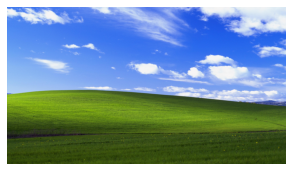

In [3]:
img = Image.open(Path.home()/"Pictures"/"xp.jpg")
show_image(img)

In [4]:
img.shape

(2160, 3840)

<AxesSubplot:>

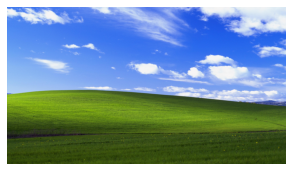

In [5]:
inp = tensor(img).permute(2, 0, 1).expand(5, 3, *img.shape).float() / 255
inp.dtype, inp.shape, inp[0][1][:20]
show_image(inp[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 4319, 7679])


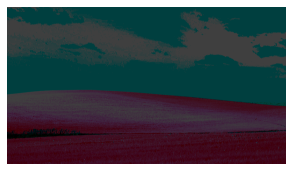

In [6]:
conv1_1 = ConvLayer(3, 3, ks=1, stride=2, transpose=True)
#inp = inp.permute(1,0,2)
#inp = inp.expand(5, *inp.shape)
inp = conv1_1(inp)
show_image(inp[0])
print(inp[0].shape)

In [ ]:
conv1_1xjk

In [95]:
inp[0].shape

torch.Size([3, 2160, 3840])

In [43]:
inp[0].shape

torch.Size([3, 3840, 2160])

In [19]:
doc(ConvLayer)

class ConvLayer [source] ConvLayer ( ni , nf , ks = 3 , stride = 1 , padding = None , bias = None , ndim = 2 , norm_type = <NormType.Batch: 1> , bn_1st = True , act_cls = ReLU , transpose = False , init = 'auto' , xtra = None , bias_std = 0.01 , dilation : Union [ int , Tuple [ int , int ]]= 1 , groups : int = 1 , padding_mode : str = 'zeros' , device = None , dtype = None ) :: Sequential 
 
 Create a sequence of convolutional ( ni to nf ), ReLU (if use_activ ) and norm_type layers. 
 Show in docs

In [10]:
from fastai.tabular.all import *

In [11]:
doc(TabularModel)

class TabularModel [source] TabularModel ( emb_szs , n_cont , out_sz , layers , ps = None , embed_p = 0.0 , y_range = None , use_bn = True , bn_final = False , bn_cont = True , act_cls = ReLU(inplace=True) , lin_first = True ) :: Module 
 
 Basic model for tabular data. 
 Show in docs

### Further Research

1. Write your own custom head and try training the pet recognizer with it. See if you can get a better result than fastai's default.
1. Try switching between `AdaptiveConcatPool2d` and `AdaptiveAvgPool2d` in a CNN head and see what difference it makes.
1. Write your own custom splitter to create a separate parameter group for every ResNet block, and a separate group for the stem. Try training with it, and see if it improves the pet recognizer.
1. Read the online chapter about generative image models, and create your own colorizer, super-resolution model, or style transfer model.
1. Create a custom head using nearest neighbor interpolation and use it to do segmentation on CamVid.

In [1]:
## hide
#!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

In [2]:
#hide
from fastbook import *

In [3]:
#hide
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
    
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
    
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [5]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [12]:
body = create_body(resnet50, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/pawel/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [44]:
head = create_head(512*2, 2, bn_final=True, lin_ftrs=[40, 60, 80])

In [60]:
class MyModel(Module):
    def __init__(self, body, head):
        self.encoder, self.head = body, head
        
    def forward(self, x1, x2):
        return self.head(torch.cat([self.encoder(x1), self.encoder(x2)], dim=1))

In [61]:
model = MyModel(body, head)

In [62]:
def loss_func(ins, out):
    return nn.CrossEntropyLoss()(ins, out.long())

In [63]:
def siameese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [64]:
learn = Learner(dls, model, loss_func=loss_func, splitter=siameese_splitter)

In [65]:
learn.freeze()

In [66]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,time


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9f65460e50>
Traceback (most recent call last):
  File "/home/pawel/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/pawel/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.9/multiprocessing/popen_fork.py", line 36, in wait
    def wait(self, timeout=None):
KeyboardInterrupt: 


KeyboardInterrupt: 